In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [3]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss,grangercausalitytests

In [7]:
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [6]:
dfSamples = pd.read_csv('samples.csv', index_col = 0, parse_dates = True)
dfSamples.index.freq = 'MS'
dfSamples

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62
...,...,...,...,...
1959-08-01,49,73,9338,58
1959-09-01,41,77,9502,38
1959-10-01,64,70,9667,42
1959-11-01,37,87,9833,62


<AxesSubplot:>

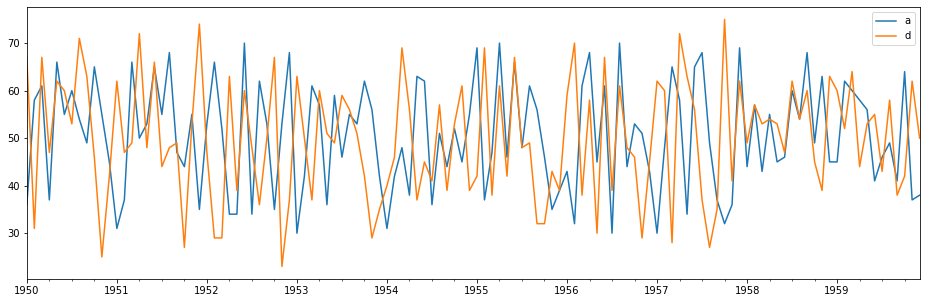

In [9]:
plt.rc("figure", figsize=(16,5))
dfSamples[['a', 'd']].plot()

<AxesSubplot:>

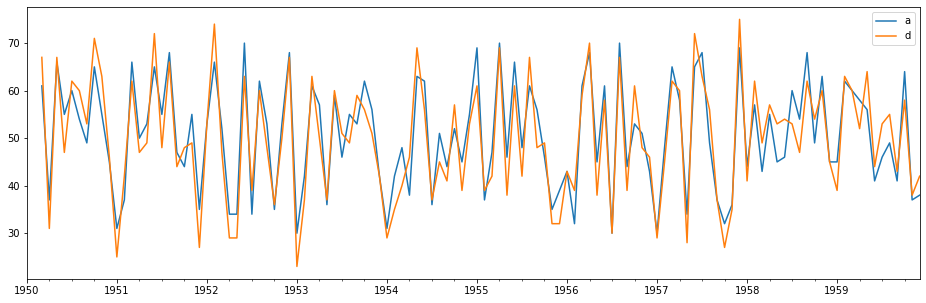

In [12]:
dfSamples['a'].iloc[2:].plot(legend = True)
dfSamples['d'].shift(2).plot(legend = True)

### Granger causality test: if p < 0.05 then shifted time series is useful

In [13]:
grangercausalitytests(dfSamples[['a', 'd']], maxlag = 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=1.7492  , p=0.1860  , df=1
likelihood ratio test: chi2=1.7365  , p=0.1876  , df=1
parameter F test:         F=1.7051  , p=0.1942  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=597.3806, p=0.0000  , df=2
likelihood ratio test: chi2=212.6514, p=0.0000  , df=2
parameter F test:         F=286.0339, p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=602.2669, p=0.0000  , df=3
likelihood ratio test: chi2=212.4789, p=0.0000  , df=3
parameter F test:         F=188.7446, p=0.0000  , df_denom=110, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=136.1258, p=0.0000  

{1: ({'ssr_ftest': (1.7051251051680953, 0.19420278116357173, 116.0, 1),
   'ssr_chi2test': (1.7492231682327875, 0.18597442074424445, 1),
   'lrtest': (1.7364915553187075, 0.18758398456227507, 1),
   'params_ftest': (1.70512510516812, 0.1942027811635669, 116.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (286.0339426255609, 6.025362015680932e-45, 113.0, 2),
   'ssr_chi2test': (597.3806235365696, 1.9074176679054406e-130, 2),
   'lrtest': (212.65135382912, 6.65802208467127e-47, 2),
   'params_ftest': (286.0339426255588, 6.025362015682994e-45, 113.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (188.7446232861623, 3.22884829414686e-43, 110.0, 3),
   'ssr_chi2test': (602.2669343040269, 3.2505045874688553e-130, 3),
   'lrtest': (212.4788575746154, 8.480665715595584e-46, 3),
   'params_ftest': (188.7446232861635, 3.2288482941458916e-43, 110.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
     

# SARIMAX

In [15]:
df = pd.read_csv('us_data.csv', sep = '\t')
df

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


### Fixing the data with datetime index

In [16]:
df['date'] = pd.to_datetime(df['Quarter'].str.replace(' ',''))
df.set_index('date', inplace = True)
df.index.freq = 'QS-JAN'
df.drop('Quarter', axis = 1, inplace = True)
df

,Consumption,Income,Production,Savings,Unemployment
date,,,,,
1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5
1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...
2018-04-01,0.983112,0.661825,1.117424,-2.723974,0.0
2018-07-01,0.853181,0.806271,1.256722,-0.085686,-0.3
2018-10-01,0.356512,0.695142,0.948148,5.031337,0.2


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 198 entries, 1970-01-01 to 2019-04-01
Freq: QS-JAN
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Consumption   198 non-null    float64
 1   Income        198 non-null    float64
 2   Production    198 non-null    float64
 3   Savings       198 non-null    float64
 4   Unemployment  198 non-null    float64
dtypes: float64(5)
memory usage: 9.3 KB


<AxesSubplot:xlabel='date'>

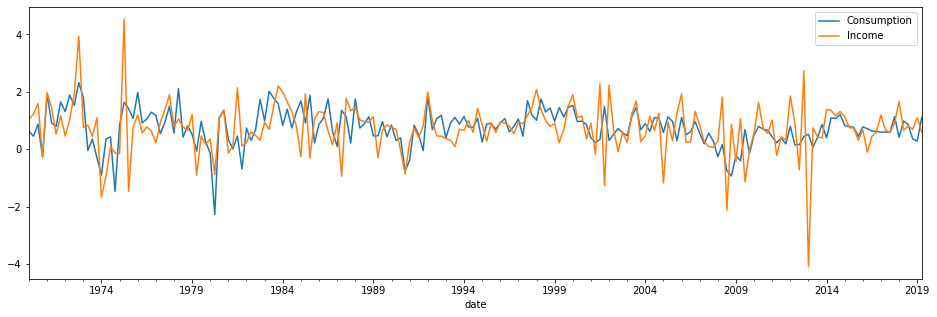

In [18]:
df[['Consumption', 'Income']].plot(legend = True)

### Checking stationarity

In [21]:
adfuller(df['Consumption']) #null hypothesis: time series in non-stationary

(-4.610123144902199,
 0.00012373240927130775,
 2,
 195,
 {'1%': -3.464337030867007,
  '5%': -2.876478799035722,
  '10%': -2.574733103221565},
 306.84324181648594)

In [20]:
adfuller(df['Income'])

(-6.7656134181274,
 2.722059468837914e-09,
 4,
 193,
 {'1%': -3.4646940755442612,
  '5%': -2.8766348847254934,
  '10%': -2.5748163958763994},
 469.11064516885546)

##### p values below 0.05: have to reject null hypothesis (time series are stationary)

### Granger causality test for consumption and income

In [22]:
grangercausalitytests(df[['Consumption', 'Income']], maxlag = 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8225  , p=0.0293  , df_denom=194, df_num=1
ssr based chi2 test:   chi2=4.8970  , p=0.0269  , df=1
likelihood ratio test: chi2=4.8372  , p=0.0279  , df=1
parameter F test:         F=4.8225  , p=0.0293  , df_denom=194, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6841  , p=0.1884  , df_denom=191, df_num=2
ssr based chi2 test:   chi2=3.4563  , p=0.1776  , df=2
likelihood ratio test: chi2=3.4262  , p=0.1803  , df=2
parameter F test:         F=1.6841  , p=0.1884  , df_denom=191, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3557  , p=0.2578  , df_denom=188, df_num=3
ssr based chi2 test:   chi2=4.2186  , p=0.2388  , df=3
likelihood ratio test: chi2=4.1736  , p=0.2433  , df=3
parameter F test:         F=1.3557  , p=0.2578  , df_denom=188, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6619  , p=0.1607  

{1: ({'ssr_ftest': (4.822459130803696, 0.029276853643505723, 194.0, 1),
   'ssr_chi2test': (4.897033241073856, 0.026902876229972755, 1),
   'lrtest': (4.837158147802484, 0.0278527586745701, 1),
   'params_ftest': (4.822459130803633, 0.029276853643507073, 194.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.6840657336352127, 0.18836203572158808, 191.0, 2),
   'ssr_chi2test': (3.4563024480890228, 0.17761247228773333, 2),
   'lrtest': (3.426181480907303, 0.18030764638208824, 2),
   'params_ftest': (1.6840657336352367, 0.18836203572157892, 191.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3557106457032828, 0.2577711331690909, 188.0, 3),
   'ssr_chi2test': (4.21856770072564, 0.23880946864445052, 3),
   'lrtest': (4.173583750414139, 0.2433199959852974, 3),
   'params_ftest': (1.355710645703276, 0.2577711331690967, 188.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [23]:
grangercausalitytests(df[['Income','Consumption']],maxlag=4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.7569 , p=0.0000  , df_denom=194, df_num=1
ssr based chi2 test:   chi2=23.1088 , p=0.0000  , df=1
likelihood ratio test: chi2=21.8509 , p=0.0000  , df=1
parameter F test:         F=22.7569 , p=0.0000  , df_denom=194, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.6515  , p=0.0001  , df_denom=191, df_num=2
ssr based chi2 test:   chi2=19.8083 , p=0.0000  , df=2
likelihood ratio test: chi2=18.8701 , p=0.0001  , df=2
parameter F test:         F=9.6515  , p=0.0001  , df_denom=191, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.8899  , p=0.0000  , df_denom=188, df_num=3
ssr based chi2 test:   chi2=30.7745 , p=0.0000  , df=3
likelihood ratio test: chi2=28.5747 , p=0.0000  , df=3
parameter F test:         F=9.8899  , p=0.0000  , df_denom=188, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.9666  , p=0.0000  

{1: ({'ssr_ftest': (22.756900160084378, 3.606706940851373e-06, 194.0, 1),
   'ssr_chi2test': (23.108810987302178, 1.5308757911111413e-06, 1),
   'lrtest': (21.850903275624887, 2.9467784974026428e-06, 1),
   'params_ftest': (22.756900160084328, 3.6067069408514184e-06, 194.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (9.6514885484608, 0.00010161291146155666, 191.0, 2),
   'ssr_chi2test': (19.808290633490234, 4.996712260352327e-05, 2),
   'lrtest': (18.87005895411079, 7.98764511990509e-05, 2),
   'params_ftest': (9.651488548460756, 0.0001016129114615614, 191.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (9.889918695760967, 4.361586242578659e-06, 188.0, 3),
   'ssr_chi2test': (30.774481047979602, 9.482496572962714e-07, 3),
   'lrtest': (28.574728851674934, 2.7509226577650115e-06, 3),
   'params_ftest': (9.889918695760983, 4.361586242578561e-06, 188.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1.,

##### Income affects consumption

### Creating auto-ARIMA model (exogeneous model ARIMAX or SARIMAX)

In [24]:
stepwise_fit = auto_arima(df['Consumption'], seasonal = False, d = 0, stepwise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=371.304, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=555.010, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=416.651, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=481.964, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=369.408, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=460.928, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=368.496, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=369.728, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=385.064, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=355.926, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=372.948, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=366.649, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=356.166, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=354.467, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=369.5

### Best model is ARIMA(3, 0, 0)

In [25]:
model = SARIMAX(df['Consumption'], order = (3, 0, 0), seasonal_order = (0, 0, 0, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -178.619
Date:                Fri, 29 Apr 2022   AIC                            365.237
Time:                        18:12:46   BIC                            378.390
Sample:                    01-01-1970   HQIC                           370.561
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3011      0.048      6.323      0.000       0.208       0.394
ar.L2          0.2558      0.051      5.057      0.000       0.157       0.355
ar.L3          0.3229      0.056      5.729      0.000       0.212       0.433
sigma2         0.3533      0.025     13.938      0.000       0.304       0.403
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                50.94
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Forecasting

In [26]:
train = df.iloc[:-4]
test = df.iloc[-4:]

In [27]:
model = SARIMAX(train['Consumption'], order=(3, 0, 0), seasonal_order=(0, 0, 0, 0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  194
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -176.085
Date:                Fri, 29 Apr 2022   AIC                            360.170
Time:                        18:14:26   BIC                            373.242
Sample:                    01-01-1970   HQIC                           365.463
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3016      0.048      6.264      0.000       0.207       0.396
ar.L2          0.2604      0.051      5.092      0.000       0.160       0.361
ar.L3          0.3181      0.057      5.552      0.000       0.206       0.430
sigma2         0.3572      0.026     13.759      0.000       0.306       0.408
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                49.65
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
start = len(train)
end = start + len(test) - 1

In [29]:
predictions=results.predict(start = start, end = end, dynamic = False).rename('SARIMA')

<AxesSubplot:xlabel='date'>

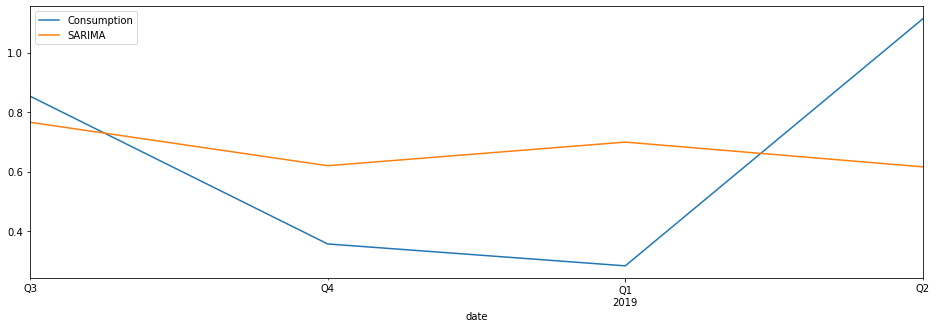

In [30]:
ax = test['Consumption'].plot(legend = True)
predictions.plot(legend = True)

In [31]:
mean_absolute_percentage_error(test['Consumption'], predictions)

0.6895530790097816

### Exogeneous model

In [32]:
modelExog = SARIMAX(train['Consumption'], exog = train['Income'], order = (3, 0, 0), seasonal_order = (0, 0, 0, 0))
resultsExog = modelExog.fit()
resultsExog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  194
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -168.943
Date:                Fri, 29 Apr 2022   AIC                            347.886
Time:                        18:19:21   BIC                            364.226
Sample:                    01-01-1970   HQIC                           354.503
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Income         0.1782      0.032      5.558      0.000       0.115       0.241
ar.L1          0.2171      0.054      4.003      0.000       0.111       0.323
ar.L2          0.3444      0.057      6.065      0.000       0.233       0.456
ar.L3          0.2838      0.057      4.951      0.000       0.171       0.396
sigma2         0.3321      0.025     13.041      0.000       0.282       0.382
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):                36.40
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
predictionsExog = resultsExog.predict(start = start, end = end, exog = test['Income'], dynamic = False).rename('SARIMAX')

### Comparing forecasts

<AxesSubplot:xlabel='date'>

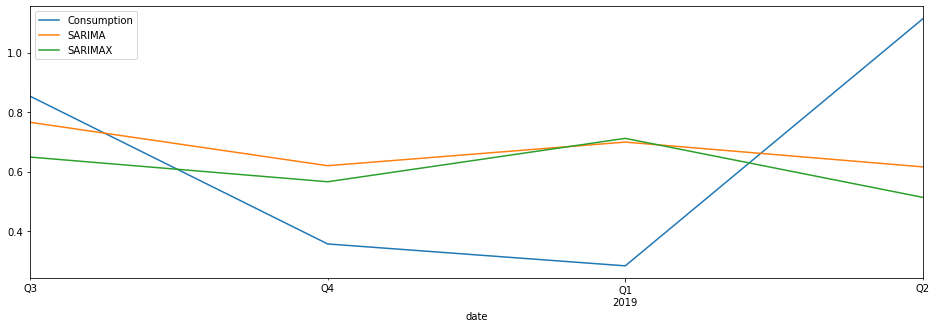

In [34]:
ax = test['Consumption'].plot(legend = True)
predictions.plot(legend = True)
predictionsExog.plot(legend = True)

In [35]:
mean_absolute_percentage_error(test['Consumption'], predictionsExog)

0.7201050749088498

# Vector AR model

In [37]:
df1 = df[['Consumption', 'Income']]
df1

,Consumption,Income
date,,
1970-01-01,0.618566,1.044801
1970-04-01,0.451984,1.225647
1970-07-01,0.872872,1.585154
1970-10-01,-0.271848,-0.239545
1971-01-01,1.901345,1.975925
...,...,...
2018-04-01,0.983112,0.661825
2018-07-01,0.853181,0.806271
2018-10-01,0.356512,0.695142


In [38]:
trainVAR = df1.iloc[:-4]
testVAR = df1.iloc[-4:]

In [39]:
for i in range(1, 10):
    modelVAR = VAR(trainVAR)
    resultsVAR = modelVAR.fit(i)
    print('order= ', i)
    print('AIC= ', resultsVAR.aic)
    print('')

order=  1
AIC=  -1.44355774811431

order=  2
AIC=  -1.4427021710347259

order=  3
AIC=  -1.47905868013255

order=  4
AIC=  -1.492913921116744

order=  5
AIC=  -1.555900188730903

order=  6
AIC=  -1.528106286909765

order=  7
AIC=  -1.5045248025067985

order=  8
AIC=  -1.4866123239137758

order=  9
AIC=  -1.4389807769810683



### Using the best model VAR(5) - it had the lowest AIC

In [45]:
modelVAR = VAR(trainVAR)
resultsVAR = modelVAR.fit(5)
resultsVAR.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 29, Apr, 2022
Time:                     18:25:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.17855
Nobs:                     189.000    HQIC:                  -1.40303
Log likelihood:          -367.326    FPE:                   0.211055
AIC:                     -1.55590    Det(Omega_mle):        0.188477
--------------------------------------------------------------------
Results for equation Consumption
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.349013         0.087649            3.982           0.000
L1.Consumption         0.189323         0.077975            2.428           0.015
L1.Income              0.108857         0.054103  

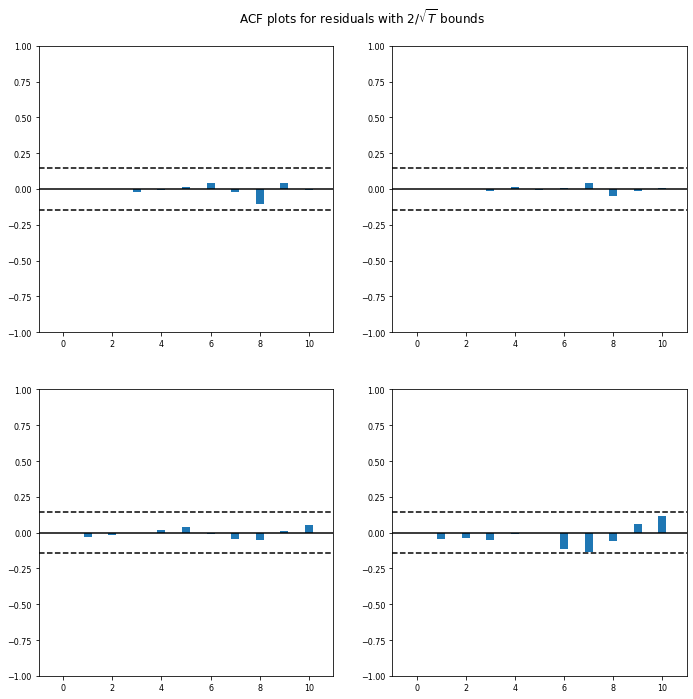

In [46]:
resultsVAR.plot_acorr();

In [48]:
lag_order = resultsVAR.k_ar
lag_order

5

In [49]:
predictedValues = resultsVAR.forecast(df1.values[-lag_order:], 4)
predictedValues

array([[0.58313943, 0.65003969],
       [0.62821021, 0.31107678],
       [0.76946343, 0.80071605],
       [0.69544088, 0.75463026]])

In [50]:
testValuesConsumption = testVAR['Consumption'].values
testValuesConsumption

array([0.85318135, 0.35651203, 0.28288547, 1.1135167 ])

In [51]:
testValuesIncome = testVAR['Income'].values
testValuesIncome

array([0.80627128, 0.69514222, 1.10075295, 0.5933995 ])

In [52]:
mean_absolute_percentage_error(testValuesConsumption, predictedValues[:, 0])

0.7935302535890598

In [53]:
mean_absolute_percentage_error(testValuesIncome, predictedValues[:, 1])

0.32263769174292994

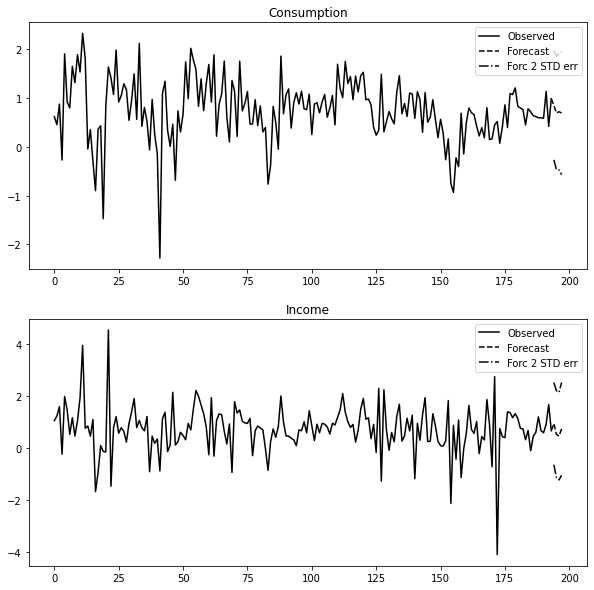

In [54]:
resultsVAR.plot_forecast(4);